In [1]:
# this is to make the Jupyter notebook as wide as the screen (on the Mac at least)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%config InlineBackend.figure_format ='retina'

In [8]:
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
import gc
from BBP_RTQC import rd_BBP, rd_WMOmeta 
from BBP_RTQC_global_vars import *
from BBP_RTQC_paths import *
import os
import subprocess
import xarray as xr
from BBP_RTQC_global_vars import *
import ipdb
import string

In [9]:
DIN_PLOTS = '/fast_scratch/BBP_RTQC/plots/'
MAIN_DIR = '/users/modellers/gdal/scratch/network/BBP_RTQC/Data/202112-ArgoData/'

In [27]:
egs = {'MD'    : ['1901339_001', '7900561_008', '6901004_041'],
       'HDV'   : ['3901531_125'],
       'Neg'    : ['6901654_056', '6901151_007'],
       'NP'    : ['6901151_079'],
       'PH'    : ['6903197_026']
      }

In [28]:
def rd_data(nm):

    # read metadata    
    VERBOSE = False
    wmo, prf = nm.split("_")
    dac = glob.glob(DIN_PLOTS + '*' + wmo + '/*' + prf + '*')[0].split('/')[-1].split('_')[0]
    iwmo = dac + '/' + wmo
    
    [ds_config, SENSOR_MODEL, SENSOR_MAKER, SENSOR_SERIAL_NO, PLATFORM_TYPE, miss_no_float, DARK_BACKSCATTERING700, SCALE_BACKSCATTERING700, KHI_BACKSCATTERING700] = rd_WMOmeta(iwmo, VERBOSE)

    # find B-file to read
    fn2glob = MAIN_DIR + "dac/" + iwmo + "/profiles/" + "B*" + iwmo.split("/")[-1] + "*_[0-9][0-9][0-9].nc"
    fn_single_profiles = np.sort(glob.glob(fn2glob))
    ifn = [i for i,item in enumerate(fn_single_profiles) if prf in item]
    fn_p = fn_single_profiles[ifn][0]

    # read B-file
    [ PRES, BBP700, JULD, LAT, LON, BBP700mf1, miss_no_prof, PARK_PRES, maxPRES, innan, COUNTS] = rd_BBP(fn_p, miss_no_float, ds_config, VERBOSE)
    
    return PRES, BBP700, wmo, prf, PARK_PRES

In [29]:
# def plt_eg(PRES, BBP, wmo, prf, iT):

#     fig, ax = plt.subplots(1, figsize=(5,7))
    
#     innan = np.where(~np.isnan(BBP))[0]
#     x = BBP[innan]
#     y = PRES[innan]

#     ax.plot(x, y, 'k-', lw=1)
#     ax.scatter(x, y, c='k', s=10, alpha=0.5)
#     ax.set_xlabel('BBP [1/m]', fontsize = 16, fontweight = 'bold')    
#     ax.set_ylabel('PRES [dbar]', fontsize = 16, fontweight = 'bold')
#     ax.tick_params(axis='both', which='major', labelsize=16)
#     ax.grid('on', ls='--')
#     ax.set_ylim([2000, 0])
#     ax.set_title(wmo + '_' + prf, fontsize = 16, fontweight = 'bold')
#     ax.set_xlim([-0.001, 0.015])    
    
#     if 'HDV' in iT:
#         ax.plot([C_DEEP_BBP700_THRESH, C_DEEP_BBP700_THRESH], [2000, 0], ls='--', c='k')

        
#     elif 'GR' in iT:
#         ax.plot([A_MIN_BBP700, A_MIN_BBP700], [2000, 0], ls='--', c='k')
#         ax.plot([A_MAX_BBP700, A_MAX_BBP700], [2000, 0], ls='--', c='k')
#         ax.set_xlim([-0.001, 0.015])

In [47]:
def plt_all(egs, iT):
    YMAX = 1250
    N_egs = len(egs[iT])
    
    if N_egs>1:
        fig, ax = plt.subplots(1, N_egs, figsize=(5*N_egs,7))
        lbls = list(string.ascii_lowercase[0:N_egs])
    else:
        fig, ax = plt.subplots(1, 3, figsize=(5*3,7))
        ax[1].set_visible(False)
        ax[2].set_visible(False)

   
    for i,ieg in enumerate(egs[iT]):
        print(iT, ieg)
        PRES, BBP, wmo, prf, PARK_PRES = rd_data(ieg)

        innan = np.where(~np.isnan(BBP))[0]
        x = BBP[innan]
        y = PRES[innan]

        ax[i].plot(x, y, 'k-', lw=1)
        ax[i].scatter(x, y, c='k', s=10, alpha=0.5)
        ax[i].set_xlabel('BBP [1/m]', fontsize = 16, fontweight = 'bold')    
        if i == 0:
            ax[i].set_ylabel('PRES [dbar]', fontsize = 16, fontweight = 'bold')
        else:
            ax[i].tick_params(axis='y',label1On=False)

        ax[i].tick_params(axis='both', which='major', labelsize=16)
        ax[i].grid('on', ls='--')
        ax[i].set_ylim([YMAX, 0])
        ax[i].set_title(wmo + '_' + prf, fontsize = 16, fontweight = 'bold')
        ax[i].set_xlim([-0.001, 0.015])    

        if 'HDV' in iT:
            ax[i].plot([C_DEEP_BBP700_THRESH, C_DEEP_BBP700_THRESH], [YMAX, 0], ls='--', c='b')

        elif 'Neg' in iT:
            ax[i].plot([A_MIN_BBP700, A_MIN_BBP700], [YMAX, 0], ls='--', c='b')
#             ax[i].plot([A_MAX_BBP700, A_MAX_BBP700], [YMAX, 0], ls='--', c='b')
            if ("6901654_056" in ieg) | ("6901151_007" in ieg):
                ax[i].set_xlim([-0.001, 0.005])
                ax[i].set_ylim([600, -10])
        
        elif 'PH' in iT:
            ax[i].plot([-0.001, 0.015], [PARK_PRES, PARK_PRES], ls='--', c='b')
            ax[i].plot([-0.001, 0.015], [np.nanmax(PRES), np.nanmax(PRES)], ls=':', c='b')
            print(np.max(PRES))
   
        # add subplot labels
        if N_egs>1:
            font = {'family': 'arial',
                    'weight': 'bold',
                    'size': 30,
                    }
            if "6901654_056" in ieg:
                ax[i].text(0.0036, 550, '('+lbls[i]+')', fontdict=font)
            elif "6901151_007" in ieg:
                ax[i].text(0.0036, 550, '('+lbls[i]+')', fontdict=font)
            else:
                ax[i].text(0.00115, 1150, '('+lbls[i]+')', fontdict=font)


MD 1901339_001
MD 7900561_008
MD 6901004_041
HDV 3901531_125
Neg 6901654_056
Neg 6901151_007
NP 6901151_079
PH 6903197_026
nan


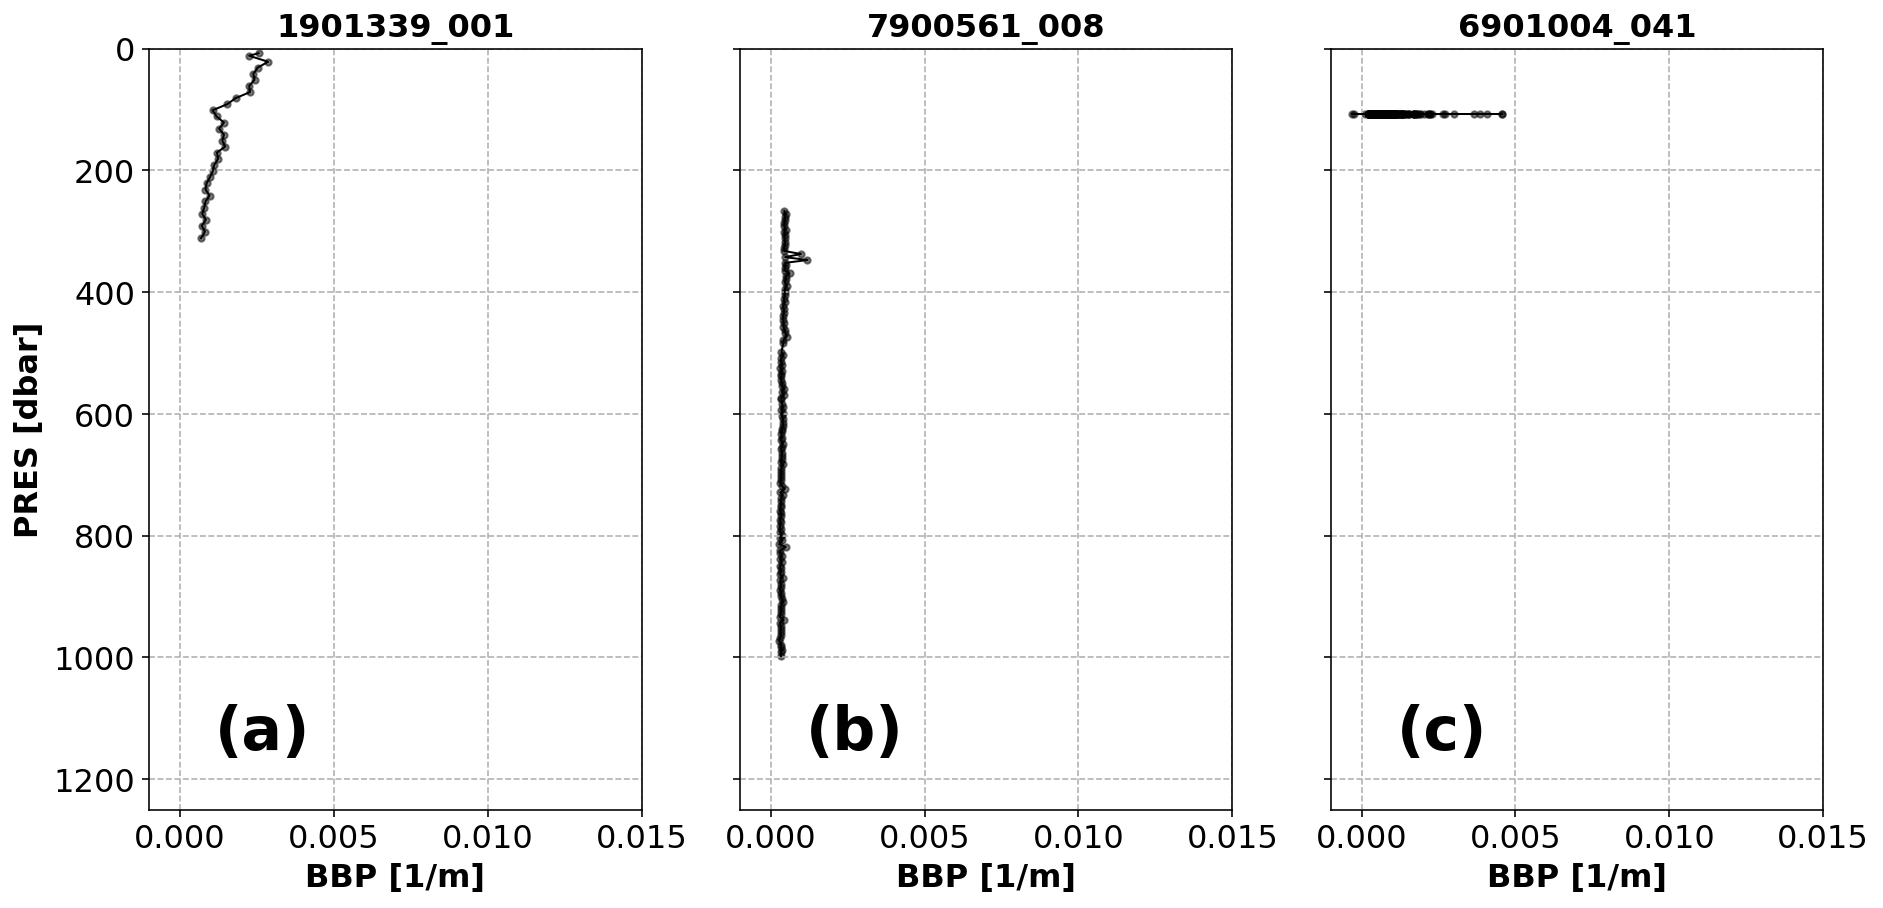

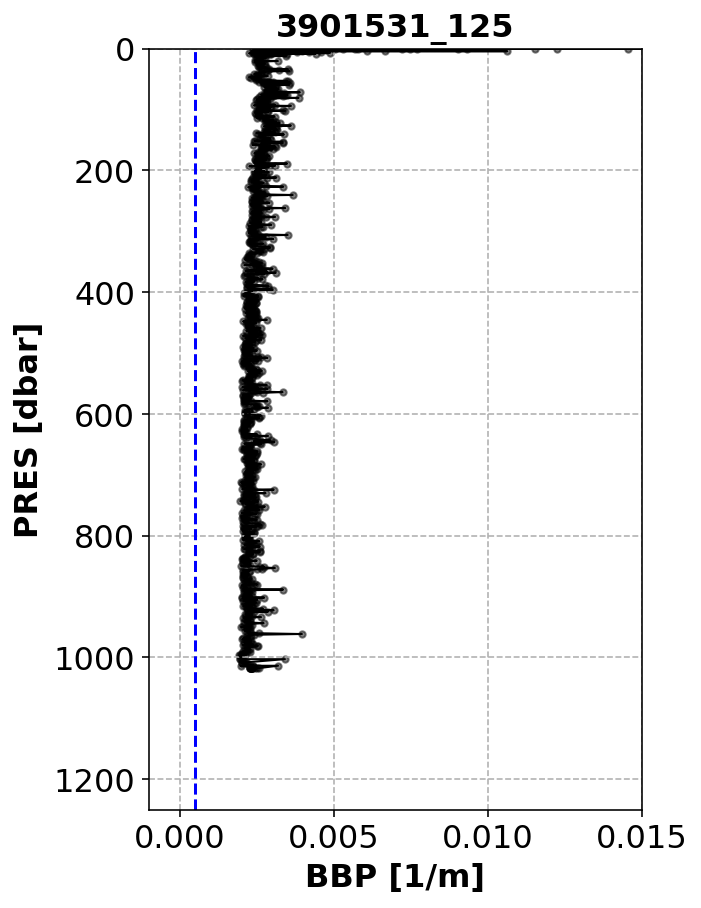

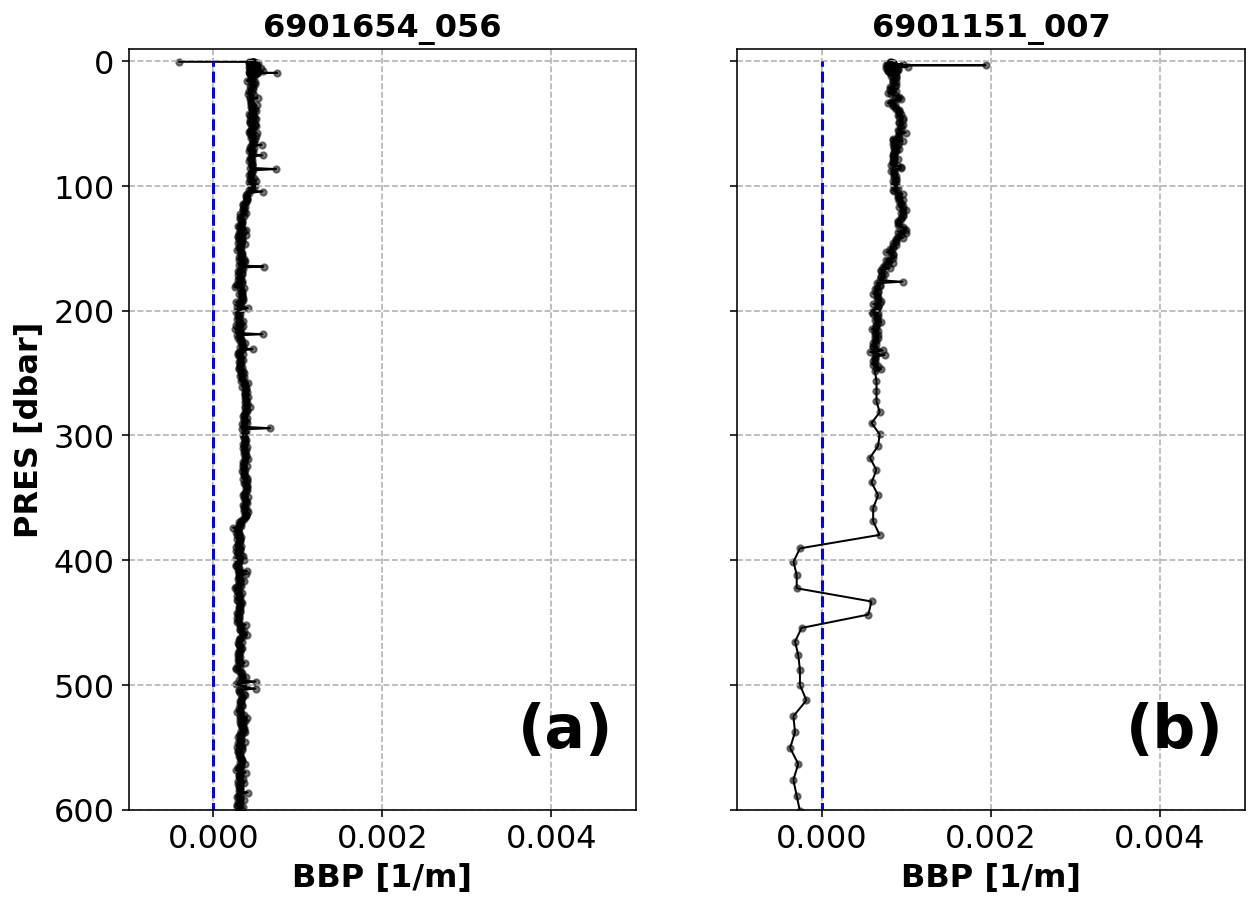

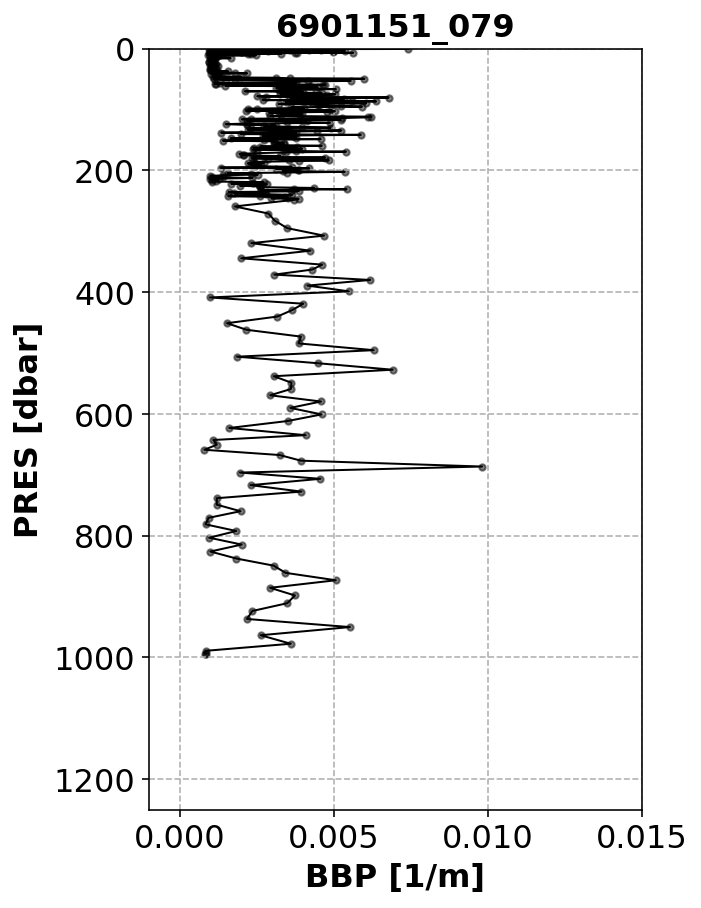

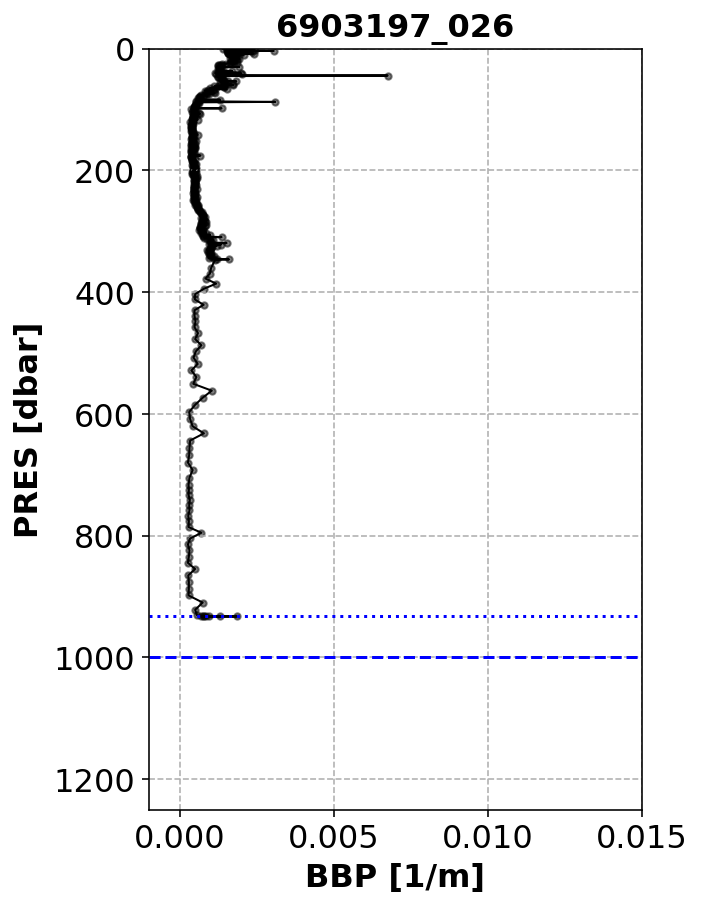

In [48]:
for iT in egs:
    plt_all(egs, iT)